In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, hamming_loss, jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



In [7]:
embeddings = np.load("chest-xray14_embeddings.npy")
annotation = pd.read_csv('Data_Entry_2017.csv')
print(annotation)

             Image Index          Finding Labels  Follow-up #  Patient ID  \
0       00000001_000.png            Cardiomegaly            0           1   
1       00000001_001.png  Cardiomegaly|Emphysema            1           1   
2       00000001_002.png   Cardiomegaly|Effusion            2           1   
3       00000002_000.png              No Finding            0           2   
4       00000003_000.png                  Hernia            0           3   
...                  ...                     ...          ...         ...   
112115  00030801_001.png          Mass|Pneumonia            1       30801   
112116  00030802_000.png              No Finding            0       30802   
112117  00030803_000.png              No Finding            0       30803   
112118  00030804_000.png              No Finding            0       30804   
112119  00030805_000.png              No Finding            0       30805   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
0 

In [8]:
embeddings = np.load("chest-xray14_embeddings.npy")
annotation = pd.read_csv('Data_Entry_2017.csv')

annotation = annotation.rename(columns={'Image Index': 'img_id', 'Finding Labels': 'class_name', 'Patient ID':'patient_id', 'Patient Age':'age', 'Patient Gender': 'gender', 'View Position': 'view_position'})


annotation['class_name'] = annotation['class_name'].str.split('|')
knowledge_graph = annotation.copy()

preprocessed = annotation.explode('class_name').reset_index(drop=True)
#print(exploded_df.shape)
preprocessed.head(10)




,img_id,class_name,Follow-up #,patient_id,age,gender,view_position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_001.png,Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
3,00000001_002.png,Cardiomegaly,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
4,00000001_002.png,Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
5,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
6,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
7,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,NaN
8,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,NaN
9,00000003_003.png,Hernia,3,3,76,F,PA,2698,2991,0.143,0.143,NaN


In [9]:

file_path = "selected_png_list.txt"
ids = []

with open(file_path, 'r') as file:
    for line in file:
        full_path = line.strip()  
        filename = os.path.basename(full_path)
        ids.append(filename)

label_dict = annotation.set_index('img_id')['class_name'].to_dict()

labels = []
for id in ids:
    if label_dict[id] == 'No Finding':
        labels.append(0)
    else:
        labels.append(1)

df = embeddings

mc_df = df - np.mean(df, axis=0)
N, k = mc_df.shape

S = (1/N) * mc_df.transpose() @ mc_df
print(S.shape)

eig_val, eig_vectors = np.linalg.eigh(S)

eig_val_desc = eig_val[::-1]
eig_vectors_desc = eig_vectors[:, ::-1]

U = eig_vectors_desc[:, :343]

X_reduced = mc_df @ U

print(X_reduced.shape)




(512, 512)
(9600, 343)


In [ ]:
# Create embeddings train/test split.
# Find the 80% index.
cutoff_inx = int(len(embeddings) * 0.8)

# Split the dataset.
X_train = embeddings[0:cutoff_inx]
X_test = embeddings[cutoff_inx:]
y_test = labels[cutoff_inx:]
y_train = labels[0:cutoff_inx]

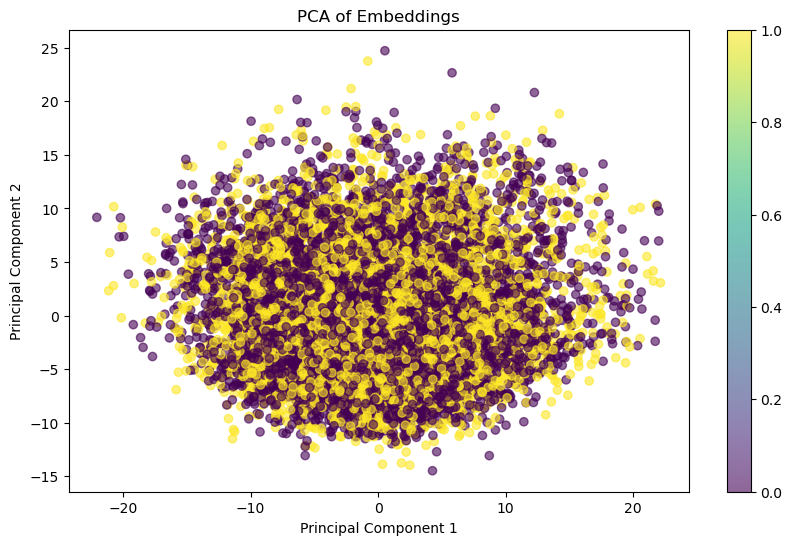

In [ ]:

scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Initialize PCA, here we are reducing to 2 dimensions for easy visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(embeddings_scaled)

# Plotting the results
def plot_pca(principal_components, labels):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.title('PCA of Embeddings')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(scatter)
    plt.savefig('pca.png', dpi = 600)
    plt.show()

plot_pca(principal_components, labels)

## Binary Classification
Instead of one hot encoding each possible outomce and doing a one vs rest logistic classifier, we want to do binary classification if there is a 
disease outcomne or not. This should theoretically improve the accuracy of the model.


# Hand Iplementation

## Logistic Regression
1. Implement Sigmoid function - hard assignment of 0 to 1.
2. Implement a loss function.
3. Implement gradient descent.
4. Prediction function.

In [ ]:
# Undersampling
def undersample(X, y):
    # Convert to numpy arrays for easier manipulation
    X = np.array(X)
    y = np.array(y)
    
    # Find the indices of each class
    class0_indices = np.where(y == 0)[0]
    class1_indices = np.where(y == 1)[0]
    
    # Find the number of instances in the smaller class
    n_min = min(len(class0_indices), len(class1_indices))
    
    # Randomly select n_min indices from each class
    np.random.shuffle(class0_indices)
    np.random.shuffle(class1_indices)
    class0_indices = class0_indices[:n_min]
    class1_indices = class1_indices[:n_min]
    
    # Concatenate the indices and extract the samples
    undersampled_indices = np.concatenate((class0_indices, class1_indices))
    X_undersampled = X[undersampled_indices]
    y_undersampled = y[undersampled_indices]
    
    return X_undersampled, y_undersampled



In [97]:
# Implement a sigmoid function.

def sigmoid(x):
    return 1 / (1 + np.exp(-x - 1))


# Compute cross entropy loss
def compute_loss(y, y_hat):
    # Ensure that both y and y_hat are NumPy arrays
    y = np.array(y)
    y_hat = np.array(y_hat)

    # Avoid division by zero and log domain issues
    epsilon = 1e-15
    y_hat = np.clip(y_hat, epsilon, 1 - epsilon)
    
    # Compute the binary cross-entropy loss
    loss = -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
    return loss


# Predict function
def predict(X, weights, bias, threshold = 0.5):
    z = np.dot(X, weights) + bias
    y_pred = sigmoid(z)
    return (y_pred >= threshold).astype(int)
    #return y_pred.round()  # returns class labels based on threshold of 0.5


# Implement gradient descent.
def grad_desc(X, y, num_iterations, learning_rate, lambda_param, decay):
    # Perform feature scaling
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0, ddof= 0)

    # Find the shape of X
    X = np.array(X)
    
    m, n = X.shape


    # Set the bias.
    bias = np.random.random()

    # Set weights.
    weights = (np.random.randn(n) * 2 - 1) * 0.05
    #weights = np.zeros(n)

    for i in range(num_iterations):


        # Do the linear combination of the weights plus biases.
        z = np.dot(X, weights) + bias
        # Do the prediction with the current weights.

        predicted = sigmoid(z)
        # Find change in weights. (Calculate the gradient).
        deltaweights = np.dot(X.T, (predicted - y)) / m + lambda_param * (weights) / m
        deltabias = np.sum(predicted - y) / m

        # Update the weights and biases.
        weights -= learning_rate*deltaweights
        bias -= learning_rate*deltabias

        loss = compute_loss(y, predicted)
        # Print out every one hundred steps.

        learning_rate *= decay
    print("Loss:", loss)
    return weights, bias


# Precision, Recall, and F1 Score calculation
def calculate_precision_recall_f1(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)


    TP = np.sum((y_pred == 1) & (y_true == 1))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    TN = np.sum((y_pred == 0) & (y_true == 0))
    print(TP, FP, TN, FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    acc = (TP+TN) / (TP+FP+TN+FN)
    return precision, recall, f1_score, acc


def TestWeightsBiases(X_test, y_test, weights, biases):
    # Make predictions
    predictions = predict(X_test, weights, biases)
    # Evaluate precision, recall, and F1 score
    precision, recall, f1_score, acc = calculate_precision_recall_f1(y_test, predictions)

    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1_score:.2f}, Accuracy: {acc:.2f}")
    return acc, f1_score

def k_fold_cross_validation(X, y, K, num_iterations, learning_rate, lambda_param):
    fold_size = len(X) // K
    accuracies = []
    
    for k in range(K):
        start = k * fold_size
        end = start + fold_size
        X_valid = X[start:end]
        y_valid = y[start:end]
        X_train = np.concatenate([X[:start], X[end:]])
        y_train = np.concatenate([y[:start], y[end:]])

        weights, bias = grad_desc(X_train, y_train, num_iterations, learning_rate, lambda_param)
        y_pred = predict(X_valid, weights, bias)
        accuracy = np.mean(y_pred == y_valid)
        accuracies.append(accuracy)

    return np.mean(accuracies)

In [ ]:
# Undersample and balance the classes.
X_train, y_train = undersample(X_train, y_train)

In [ ]:
weights, biases = grad_desc(X_train, y_train, 500, 0.125, lambda_param=1e-10, decay = 0.9995)
TestWeightsBiases(X_test, y_test, weights, biases)


Step 0, Loss: 1.4304118724445092
Step 1, Loss: 1.2708947221306528
Step 2, Loss: 1.2078761934118598
Step 3, Loss: 1.1689594796244014
Step 4, Loss: 1.1390665761811982
Step 5, Loss: 1.1143487779734031
Step 6, Loss: 1.0930739879064704
Step 7, Loss: 1.074214352675588
Step 8, Loss: 1.0571122079742834
Step 9, Loss: 1.0413371513121001
Step 10, Loss: 1.0266038784131255
Step 11, Loss: 1.012720722482397
Step 12, Loss: 0.9995566773537936
Step 13, Loss: 0.9870201511004262
Step 14, Loss: 0.9750452784570273
Step 15, Loss: 0.9635831141369848
Step 16, Loss: 0.9525959689405773
Step 17, Loss: 0.9420537610828721
Step 18, Loss: 0.931931654919145
Step 19, Loss: 0.9222085202346669
Step 20, Loss: 0.9128659144798115
Step 21, Loss: 0.9038873991703456
Step 22, Loss: 0.8952580711413131
Step 23, Loss: 0.8869642333791262
Step 24, Loss: 0.878993157910181
Step 25, Loss: 0.8713329106372841
Step 26, Loss: 0.86397221890714
Step 27, Loss: 0.8569003693965059
Step 28, Loss: 0.8501071281593021
Step 29, Loss: 0.8435826773472

# Split data into individual classifications.

In [10]:
import random
# Define an undersampling function.
def undersample(list1, list2):
    # Determine the size of the smaller list
    smaller_size = min(len(list1), len(list2))

    # Randomly sample from both lists to make them the same size
    new_list1 = random.sample(list1, smaller_size)
    new_list2 = random.sample(list2, smaller_size)

    return new_list1, new_list2

In [11]:
# Create a list of unique features.
classes = annotation["class_name"]
uniq_classes = set()
for multiclass in classes:
    for classification in multiclass:
        uniq_classes.add(classification)

uniq_classes = list(uniq_classes)

# Now we want to create a list for each type of class.
dataset_individual = [[]] * len(uniq_classes)

# Now we need a dictionary to map the class to the index.
map_individual_index = dict(zip(uniq_classes, range(0, len(uniq_classes))))

# We now want to populate each item of the dataset with our image id's if it belongs to that class.
for i, _ in enumerate(uniq_classes):
    # Get list of image id's for the ith disease state.
    class_ids = annotation[annotation['class_name'].apply(lambda x: uniq_classes[i] in x)]['img_id']
    class_ids = list(class_ids)
    class_ids = set(class_ids).intersection(set(ids))
    dataset_individual[i] = class_ids

# Find the no finding part of the array.
idx_no_finding = map_individual_index['No Finding']
no_findings = dataset_individual[idx_no_finding]

print(no_findings)
#dataset_individual = dataset_individual[0:idx_no_finding] +  dataset_individual[idx_no_finding+1:]
dataset_individual[idx_no_finding] = []

for i, _ in enumerate(uniq_classes):
    undersample_one, undersample_two = undersample(list(dataset_individual[i]), list(no_findings))
    dataset_individual[i] = list(undersample_two) + list(undersample_one)
    # Shuffle the new list
    random.shuffle(dataset_individual[i])

count = 0
for i in dataset_individual:
    print(len(i))
    count += len(i)

print(f"total length is now {count}")



{'00010531_059.png', '00010640_012.png', '00020087_000.png', '00008576_002.png', '00023868_000.png', '00015690_000.png', '00013739_003.png', '00001182_002.png', '00009506_000.png', '00007317_007.png', '00014290_002.png', '00023260_003.png', '00001699_002.png', '00005993_006.png', '00012148_002.png', '00001307_001.png', '00007623_000.png', '00010585_008.png', '00025839_004.png', '00014265_014.png', '00022870_003.png', '00016484_028.png', '00010569_006.png', '00019610_001.png', '00026505_001.png', '00006295_000.png', '00017852_016.png', '00001113_000.png', '00016975_011.png', '00001738_004.png', '00006151_000.png', '00016787_001.png', '00008339_004.png', '00016831_003.png', '00005545_002.png', '00026204_001.png', '00006670_005.png', '00000239_001.png', '00005921_000.png', '00021185_000.png', '00014733_000.png', '00029165_010.png', '00022065_031.png', '00012832_008.png', '00030434_002.png', '00001178_000.png', '00020489_002.png', '00011771_002.png', '00012681_043.png', '00026859_000.png',

In [23]:
# Create labels for the dataset.
labels_individual = []
for key, val in map_individual_index.items():
    print(val)
    labels_per_ind = []
    for i in dataset_individual[val]:
        if annotation[annotation["img_id"] == i]["class_name"].iloc[0] == ["No Finding"]:
            labels_per_ind.append(1)
        else:
            labels_per_ind.append(0)
    labels_individual.append(labels_per_ind)





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [13]:
with open("selected_png_list.txt") as f:
    lines = f.readlines()
    lines = [line.split("/") for line in lines]
    lines = [line[-1].strip("\n") for line in lines]

dict_img_index = {}
for i, line in enumerate(lines):
    dict_img_index[line] = i



In [14]:
print(dict_img_index)

{'00004118_002.png': 0, '00005241_000.png': 1, '00005681_020.png': 2, '00006469_000.png': 3, '00005921_000.png': 4, '00006024_004.png': 5, '00004875_000.png': 6, '00003948_001.png': 7, '00005232_000.png': 8, '00005954_003.png': 9, '00005524_001.png': 10, '00005462_000.png': 11, '00006500_004.png': 12, '00005480_000.png': 13, '00006271_027.png': 14, '00006149_000.png': 15, '00004001_010.png': 16, '00004920_004.png': 17, '00006570_000.png': 18, '00005722_005.png': 19, '00004007_005.png': 20, '00005778_027.png': 21, '00006008_000.png': 22, '00004342_056.png': 23, '00004490_001.png': 24, '00006564_000.png': 25, '00005801_001.png': 26, '00005456_005.png': 27, '00006497_003.png': 28, '00004066_001.png': 29, '00005004_002.png': 30, '00003996_019.png': 31, '00006022_000.png': 32, '00004123_006.png': 33, '00004823_000.png': 34, '00006027_000.png': 35, '00004268_009.png': 36, '00006304_013.png': 37, '00003989_019.png': 38, '00005532_030.png': 39, '00005736_000.png': 40, '00003957_002.png': 41, '

In [15]:
print(dataset_individual[0])

['00016222_002.png', '00002981_003.png', '00002633_027.png', '00005192_001.png', '00026101_000.png', '00004858_088.png', '00026925_024.png', '00006122_000.png', '00014346_014.png', '00011859_007.png', '00013119_008.png', '00021938_000.png', '00008051_046.png', '00030689_001.png', '00026027_008.png', '00002425_004.png', '00016231_008.png', '00002275_005.png', '00003961_001.png', '00020671_019.png', '00012342_005.png', '00010092_032.png', '00019062_002.png', '00026798_001.png', '00012021_023.png', '00005918_009.png', '00018112_000.png', '00000583_033.png', '00009705_000.png', '00018253_022.png', '00009330_004.png', '00024962_000.png', '00004870_000.png', '00011679_004.png', '00004300_000.png', '00020076_000.png', '00019308_006.png', '00025857_002.png', '00022951_000.png', '00014064_000.png', '00012905_004.png', '00006868_003.png', '00005448_011.png', '00000054_001.png', '00009643_000.png', '00001222_003.png', '00008488_000.png', '00021584_005.png', '00000761_010.png', '00008251_003.png',

In [16]:
print(dict_img_index)
dataset_individual_embeddings = dataset_individual.copy()
# Now we want to construct the embeddings dataset for each classification.
for i, _ in enumerate(dataset_individual):
    print(i)
    for item in dataset_individual[i]:
        print(item)
        print(dict_img_index[item])
        dataset_individual_embeddings[i] = [embeddings[dict_img_index[item]] for item in dataset_individual[i]] 
        #dataset_individual_embeddings[i] = [embeddings[dict_img_index[item]] for item in dataset_individual[i]]
    



{'00004118_002.png': 0, '00005241_000.png': 1, '00005681_020.png': 2, '00006469_000.png': 3, '00005921_000.png': 4, '00006024_004.png': 5, '00004875_000.png': 6, '00003948_001.png': 7, '00005232_000.png': 8, '00005954_003.png': 9, '00005524_001.png': 10, '00005462_000.png': 11, '00006500_004.png': 12, '00005480_000.png': 13, '00006271_027.png': 14, '00006149_000.png': 15, '00004001_010.png': 16, '00004920_004.png': 17, '00006570_000.png': 18, '00005722_005.png': 19, '00004007_005.png': 20, '00005778_027.png': 21, '00006008_000.png': 22, '00004342_056.png': 23, '00004490_001.png': 24, '00006564_000.png': 25, '00005801_001.png': 26, '00005456_005.png': 27, '00006497_003.png': 28, '00004066_001.png': 29, '00005004_002.png': 30, '00003996_019.png': 31, '00006022_000.png': 32, '00004123_006.png': 33, '00004823_000.png': 34, '00006027_000.png': 35, '00004268_009.png': 36, '00006304_013.png': 37, '00003989_019.png': 38, '00005532_030.png': 39, '00005736_000.png': 40, '00003957_002.png': 41, '

In [17]:
for key, val in map_individual_index.items():
    print(key, len(dataset_individual_embeddings[val]), val)

Atelectasis 1936 0
Edema 446 1
No Finding 0 2
Nodule 1068 3
Pleural_Thickening 644 4
Cardiomegaly 454 5
Pneumothorax 960 6
Hernia 54 7
Pneumonia 246 8
Fibrosis 254 9
Emphysema 424 10
Mass 984 11
Consolidation 774 12
Infiltration 3320 13
Effusion 2252 14


In [102]:
# Create embeddings train/test split.
# For Infiltration
# Find 80%
map_index_class = {value: key for key, value in map_individual_index.items()}
accs = []
f1s = []
for i in range(len(dataset_individual_embeddings)):
    print(map_index_class[i], "\n")
    if map_index_class[i] == "No Finding":
        continue        
    idx_split = int(len(dataset_individual_embeddings[i]) * 0.8)
    X_train = dataset_individual_embeddings[i][:idx_split]
    X_test = dataset_individual_embeddings[i][idx_split+1:]
    y_train = labels_individual[i][:idx_split]
    y_test =labels_individual[i][idx_split+1:]
    weights, biases = grad_desc(X_train, y_train, 750, 0.14, lambda_param=1e-2, decay = 0.999)
    acc, f1 = TestWeightsBiases(X_test, y_test, weights, biases)
    accs.append(acc)
    f1s.append(f1)

print("Average Accuracy: ", np.mean(accs))
print("Average F1-score:", np.mean(f1s))

Atelectasis 

Loss: 0.5613233728172518
184 170 16 17
Precision: 0.52, Recall: 0.92, F1 Score: 0.66, Accuracy: 0.52
Edema 

Loss: 0.18660477132730283
21 19 26 23
Precision: 0.53, Recall: 0.48, F1 Score: 0.50, Accuracy: 0.53
No Finding 

Nodule 

Loss: 0.4338301870701258
0 0 115 98
Precision: 0.00, Recall: 0.00, F1 Score: 0.00, Accuracy: 0.54
Pleural_Thickening 

Loss: 0.300911792520357
30 24 29 45
Precision: 0.56, Recall: 0.40, F1 Score: 0.47, Accuracy: 0.46
Cardiomegaly 

Loss: 0.1528576526969504
49 40 1 0
Precision: 0.55, Recall: 1.00, F1 Score: 0.71, Accuracy: 0.56
Pneumothorax 

Loss: 0.38910071994178264
89 77 17 8
Precision: 0.54, Recall: 0.92, F1 Score: 0.68, Accuracy: 0.55
Hernia 

Loss: 0.0031476183053271156
7 3 0 0
Precision: 0.70, Recall: 1.00, F1 Score: 0.82, Accuracy: 0.70
Pneumonia 

Loss: 0.052856299534233896
21 28 0 0
Precision: 0.43, Recall: 1.00, F1 Score: 0.60, Accuracy: 0.43
Fibrosis 

Loss: 0.04863515684278553
22 28 0 0
Precision: 0.44, Recall: 1.00, F1 Score: 0.61, 

Step 0, Loss: 1.3722251011330302
Step 1, Loss: 1.1663455279441182
Step 2, Loss: 1.0298175032219647
Step 3, Loss: 0.9317886469392668
Step 4, Loss: 0.85956388625681
Step 5, Loss: 0.8049671344888817
Step 6, Loss: 0.7622047801798946
Step 7, Loss: 0.7274359798911753
Step 8, Loss: 0.6981770758494618
Step 9, Loss: 0.6728166909636083
Step 10, Loss: 0.6503042282469985
Step 11, Loss: 0.6299508749068194
Step 12, Loss: 0.6112997737642571
Step 13, Loss: 0.594041761172873
Step 14, Loss: 0.5779615679946691
Step 15, Loss: 0.5629039403489947
Step 16, Loss: 0.5487524457762819
Step 17, Loss: 0.5354162092244857
Step 18, Loss: 0.522821564503228
Step 19, Loss: 0.510906754664924
Step 20, Loss: 0.4996185371628795
Step 21, Loss: 0.4889099908293683
Step 22, Loss: 0.47873908727990666
Step 23, Loss: 0.4690677496625681
Step 24, Loss: 0.459861220512899
Step 25, Loss: 0.4510876234329769
Step 26, Loss: 0.4427176446042042
Step 27, Loss: 0.43472428756459364
Step 28, Loss: 0.4270826727482222
Step 29, Loss: 0.41976986491

In [30]:
model = LogisticRegression(penalty='l2')
print(model)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

LogisticRegression()
              precision    recall  f1-score   support

           0       0.68      0.46      0.55        28
           1       0.52      0.73      0.60        22

    accuracy                           0.58        50
   macro avg       0.60      0.60      0.58        50
weighted avg       0.61      0.58      0.58        50



In [63]:

def soft_thresholding(x, lambda_):
    """Apply the soft thresholding operator which is used in Lasso."""
    if x > lambda_:
        return x - lambda_
    elif x < -lambda_:
        return x + lambda_
    else:
        return 0

def lasso_coordinate_descent(X, y, lambda_, num_iters=100):
    """
    Lasso regression using coordinate descent.

    Parameters:
        X : numpy array, shape (n_samples, n_features)
            Design matrix.
        y : numpy array, shape (n_samples,)
            Response vector.
        lambda_ : float
            Regularization parameter controlling the strength of the L1 penalty.
        num_iters : int
            Number of iterations to run the coordinate descent.

    Returns:
        numpy array, shape (n_features,)
            Coefficients of the Lasso regression.
    """
    # Number of samples and number of features
    n_samples, n_features = X.shape

    # Standardize X
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X = (X - X_mean) / X_std

    # Initialize coefficients
    beta = np.zeros(n_features)
    
    # Main loop for coordinate descent
    for _ in range(num_iters):
        for j in range(n_features):
            # Temporary copy of the coefficients to update one at a time
            temp_beta = beta.copy()
            # Remove the contribution of the j-th coefficient
            temp_beta[j] = 0
            # Residual without the contribution of the j-th feature
            r = y - X @ temp_beta
            # Calculate the correlation between the j-th feature and the residual
            rho = np.dot(X[:, j], r)
            # Soft thresholding to update the j-th coefficient
            beta[j] = soft_thresholding(rho / n_samples, lambda_)

    # Adjust coefficients for the standardization
    beta /= X_std

    return beta

# Example usage:
# Generate random data (for demonstration purposes)
np.random.seed(0)
X = embeddings
y = labels
lambda_ = 0.001

# Fit the model
coefficients = lasso_coordinate_descent(X, y, lambda_)
print("Lasso coefficients:", coefficients)


print(np.argmax(coefficients))


KeyboardInterrupt: 

In [34]:
abs_coefficients = [abs(x) for x in coefficients]
abs_coefficients = np.array(abs_coefficients)
sorted_indices = np.argsort(-abs_coefficients)
#print(sorted_indices)

sorted_beta = coefficients[sorted_indices]
print(sorted_beta)

count = 0
for coeff in sorted_beta:
    if coeff != 0:
        count += 1
print(count)


[ 1.90221687e+00 -1.84217979e+00 -1.67698365e+00  1.64187662e+00
 -1.63627536e+00  1.58019645e+00  1.53497319e+00 -1.51419781e+00
 -1.47840924e+00  1.46320665e+00 -1.42267242e+00  1.39856638e+00
 -1.39137520e+00 -1.38630110e+00 -1.38412030e+00  1.37952534e+00
  1.36310687e+00 -1.35361735e+00  1.33556477e+00  1.33377335e+00
  1.32378617e+00  1.31634732e+00 -1.30205367e+00  1.28913679e+00
 -1.24607246e+00  1.22596939e+00  1.22544349e+00  1.22505540e+00
 -1.21308290e+00  1.15353908e+00  1.14558856e+00 -1.14033341e+00
 -1.12783200e+00  1.11613853e+00  1.10117060e+00 -1.09452315e+00
 -1.09431432e+00  1.08022984e+00  1.07525730e+00  1.06012979e+00
 -1.05471631e+00 -1.04105012e+00  1.02690990e+00 -1.01416872e+00
  1.01351011e+00  9.68626342e-01 -9.68111280e-01  9.54824509e-01
 -9.52568886e-01  9.50219950e-01  9.49937443e-01  8.99767126e-01
 -8.98066210e-01  8.91392849e-01  8.78520921e-01 -8.57622499e-01
  8.41460487e-01  8.36325876e-01  8.27587468e-01  8.10979722e-01
 -8.09096995e-01 -7.98975